In [1]:
import os
import re

import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# plotting settings
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

%matplotlib inline

In [2]:
experiment_path = Path("../data/experiments/cluster/fully_observed")

In [3]:
def recursive_split(path):
    rest, tail = os.path.split(path)
    if rest in  ('', os.path.sep):
        return tail,
    return recursive_split(rest) + (tail,)

recursive_split(experiment_path)

('..', 'data', 'experiments', 'cluster', 'fully_observed')

In [4]:
def read_experiment(path):
    
    objects = path.rglob('*.csv')
    data = []
    depth = len(recursive_split(experiment_path)) + 6
    for obj in objects:
        data.append(recursive_split(obj)[0:depth] + (obj,))
    
    df = pd.DataFrame(data=data)
    columns = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "file_or_dir", "path"]
    auto_columns = []
    for i in range(df.shape[1] - len(columns)):
        auto_columns.append(f"col{i}")
    df.columns = auto_columns + columns
    df.drop(auto_columns, axis=1, inplace=True)
    df = df[df["file_or_dir"].str.endswith(".csv")] # remove sub-directories at this level
    df.rename(columns={"file_or_dir": "file"}, inplace=True)
    
    return df.reset_index(drop=True)

read_experiment(experiment_path).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file,path
0,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std_input4.csv,../data/experiments/cluster/fully_observed/Aut...
1,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_std_input4.csv,../data/experiments/cluster/fully_observed/Aut...
2,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_mean_input4.csv,../data/experiments/cluster/fully_observed/Aut...
3,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_mean_input4.csv,../data/experiments/cluster/fully_observed/Aut...
4,fully_observed,AutoKerasImputer,32,MCAR,0.3,single_all,impute_performance_mean_input8.csv,../data/experiments/cluster/fully_observed/Aut...


In [5]:
def read_prefixed_csv_files(df_in, file_prefix):
    col_pattern = f"({file_prefix}_)(\\S*)(.csv)"
    dfs = []
    for row in df_in[df_in["file"].str.startswith(file_prefix)].iterrows():
        df_new = pd.read_csv(row[1]["path"])
        df_new.rename({"Unnamed: 0": "metric"}, inplace=True, axis=1)
        df_new["experiment"] = row[1]["experiment"]
        df_new["imputer"] = row[1]["imputer"]
        df_new["task"] = row[1]["task"]    
        df_new["missing_type"] = row[1]["missing_type"]
        df_new["missing_fraction"] = row[1]["missing_fraction"]
        df_new["strategy"] = row[1]["strategy"]
        try:
            df_new["column"] = re.findall(col_pattern, row[1]["file"])[0][1]
        except:
            pass
        df_new["result_type"] = file_prefix
        dfs.append(df_new)
    return pd.concat(dfs, ignore_index=True)

In [6]:
def read_csv_files(df):
    prefixes = [
        "impute_performance_std", 
        "impute_performance_mean", 
        "downstream_performance_std", 
        "downstream_performance_mean"
    ]
    df = pd.concat([read_prefixed_csv_files(df, prefix) for prefix in prefixes], ignore_index=True)
    df["missing_fraction"] = pd.to_numeric(df["missing_fraction"])
    return df

results = read_csv_files(read_experiment(experiment_path))
results.head()

,metric,train,test,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,baseline,corrupted,imputed
0,MAE,2.423165,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
1,MSE,30.923196,32.844677,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
2,RMSE,2.642595,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
3,MAE,0.441542,1.079771,fully_observed,AutoKerasImputer,32,MCAR,0.3,single_all,input8,impute_performance_std,NaN,NaN,NaN
4,MSE,17.692893,44.049110,fully_observed,AutoKerasImputer,32,MCAR,0.3,single_all,input8,impute_performance_std,NaN,NaN,NaN


<AxesSubplot:title={'center':'Downstream Mean RMSE (imputed)'}, ylabel='Density'>

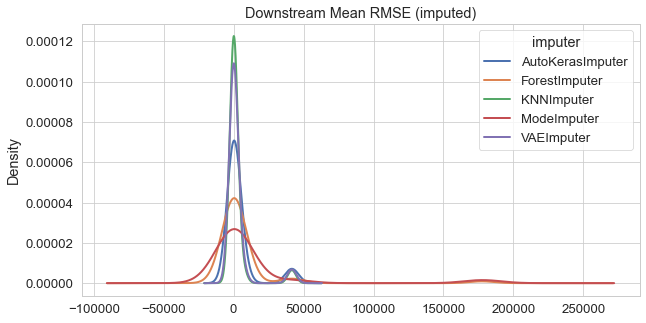

In [49]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
cols = ["imputed", "imputer"]
data = results.loc[row_idx, cols]
data = plot_data.pivot(columns="imputer", values="imputed")
data.plot(kind="kde", title="Downstream Mean RMSE (imputed)", figsize=(10,5))

In [50]:
results.head()

,metric,train,test,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,baseline,corrupted,imputed
0,MAE,2.423165,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
1,MSE,30.923196,32.844677,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
2,RMSE,2.642595,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
3,MAE,0.441542,1.079771,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,input8,impute_performance_std,NaN,NaN,NaN
4,MSE,17.692893,44.049110,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,input8,impute_performance_std,NaN,NaN,NaN


Text(0.5, 1.0, 'Imputation RMSE with 25% Confidence Band')

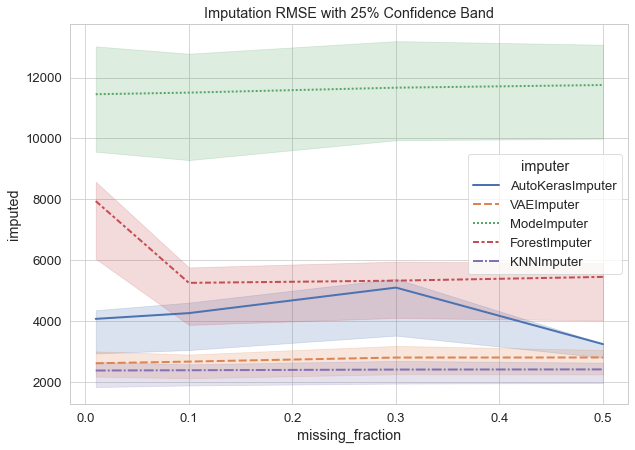

In [51]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
cols = ["imputed", "imputer", "missing_fraction"]
data = results.loc[row_idx, cols]

plt.figure(figsize=(10,7))
ax = sns.lineplot(
    data=data, 
    x="missing_fraction", 
    y="imputed", 
    hue="imputer", 
    style="imputer", 
    ci=25
)
ax.set_title("Imputation RMSE with 25% Confidence Band")

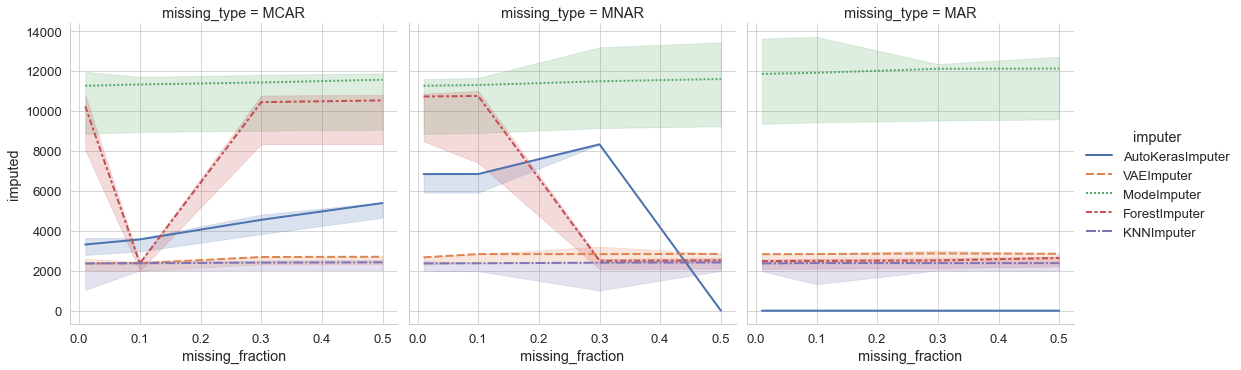

In [52]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
data = results[row_idx]

sns.relplot(
    data=data, 
    x="missing_fraction", 
    y="imputed", 
    hue="imputer", 
    style="imputer", 
    ci=25,
    col="missing_type",
    kind="line"
)